In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import re
import nltk
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from collections import Counter
from importlib import reload
import os, sys, re, json, time, datetime, shutil
import patched_numpy_io
import math

#nltk.download('stopwords')
from nltk.corpus import stopwords
import utils, vocabulary


from sklearn.metrics import confusion_matrix
import itertools

/home/heatherkoo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Specifications for Binary Classification NBOW for MBTI

In this baseline, the task is to predict the first MBTI axis (I vs. E) given a text string. We will model after the A2 assignment, with Architecture and Parameters defined below.

### Pre-Processing:
* Minimial pre-processing, only separating punctuation from text and lower-case all text
* Assigning words to numerical indices based on a fixed Vocab size, defined by word frequency in training set
* Target labels assigned to 16 integer classifiers

### Architecture:
* Encoder: Bag of Words 
* Decoder: Softmax
* Classification: 16 

### Parameters
* Batch Size: 25 
* Text length: 100
* Vocabulary size (V): ~330K - full corpus
* Embedding Size: 50
* Hidden Dimensions: 25

### Training:
* Epochs = 10 
* 80% train, 20% test
* Loss: Sparse Softmax Cross Entropy 
* Optimizers: Adagrad Optimizer

In [3]:
df = pd.read_csv('./mbti_1.csv')
df.head()

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


In [4]:
# function to tokenize and clean sentence ["Hello world."] into list of words ["hello","world"]
def clean_tokenize(sentence):
    ignore_words = ['a']
    words = re.sub("[^\w]", " ",  sentence).split() #nltk.word_tokenize(sentence)
    words_cleaned = [w.lower() for w in words if w not in ignore_words]
    stop_words = set(stopwords.words('english'))
    words_cleaned = [w for w in words_cleaned if not w in stop_words]
    return words_cleaned

In [5]:
# split posts per users into separate sentences
post = []
utype = []
user = []

for index, row in df.iterrows():
    posts = row['posts'].split('|||')
    posts_clean = []
    for sentence in posts:
        posts_clean.append(clean_tokenize(sentence))
    post.extend(posts_clean)
    utype.extend([row['type'] for i in range(len(posts))])
    user.extend([index for i in range(len(posts))])
    
short_posts = pd.DataFrame({"user": user,"type": utype,"post": post})
print(short_posts.shape)
short_posts.head()

(422845, 3)


,user,type,post
0,0,INFJ,"[http, www, youtube, com, watch, v, qsxhcwe3krw]"
1,0,INFJ,"[http, 41, media, tumblr, com, tumblr_lfouy03p..."
2,0,INFJ,"[enfp, intj, moments, https, www, youtube, com..."
3,0,INFJ,"[life, changing, experience, life]"
4,0,INFJ,"[http, www, youtube, com, watch, v, vxzeywwrdw..."


In [6]:
#split corpus into training and test set
X_train, X_test, y_train, y_test = train_test_split(short_posts['post'], short_posts['type'], test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))



338276
84569
338276
84569


In [7]:
#create  vocabulary
vocab_mbti = vocabulary.Vocabulary((utils.canonicalize_word(w) for w in utils.flatten(X_train)))

In [8]:
print (vocab_mbti.words_to_ids(['basically']))
print (vocab_mbti.ids_to_words([405]))  

[405]
['basically']


In [9]:
def pad_np_array(example_ids, max_len=100, pad_id=0):

    arr = np.full([len(example_ids), max_len], pad_id, dtype=np.int32)
    ns = np.zeros([len(example_ids)], dtype=np.int32)
    for i, ids in enumerate(example_ids):
        cpy_len = min(len(ids), max_len)
        arr[i,:cpy_len] = ids[:cpy_len]
        ns[i] = cpy_len
    return arr, ns

def tokenize_post(post_string):
    return vocab_mbti.words_to_ids(post_string)
   

In [10]:
def as_padded_array(post_ids, targets, max_len=100, pad_id=0,
                    root_only=False, df_idxs=None):
  
    
    x, ns = pad_np_array(post_ids, max_len=max_len, pad_id=pad_id)
    return x, ns, np.array(targets)

In [11]:
#tokenize training corpus

X_train=X_train.reset_index(drop=True)
X_train_ids = []

for post in range(0,(len(X_train))):
    X_train_ids.append(tokenize_post(X_train[post]))

#tokenize test set

X_test=X_test.reset_index(drop=True)
X_test_ids = []

for post in range(0,(len(X_test))):
    X_test_ids.append(tokenize_post(X_test[post]))    
    

In [12]:
train_x, train_ns, train_y = as_padded_array(X_train_ids, y_train)
test_x, test_ns, test_y = as_padded_array(X_test_ids, y_test)

In [13]:
#create integer classifiers
classifiers = list(set(train_y))
target_y_train = []
for i in range(len(train_y)):
    target_y_train.append(classifiers.index(train_y[i]))
target_y_train=np.array(target_y_train)
    
target_y_test = []
for i in range(len(test_y)):
    target_y_test.append(classifiers.index(test_y[i]))
target_y_test=np.array(target_y_test)

In [14]:
#train model using tf.estimator

import MBTI_BOW_model; reload(MBTI_BOW_model)

# Specify model hyperparameters as used by model
model_params = dict(V=vocab_mbti.size, embed_dim=50, hidden_dims=[25], num_classes=len(classifiers),
                    encoder_type='bow',
                    lr=0.1, optimizer='adagrad', beta=0.01)

checkpoint_dir = "/tmp/tf_bow_sst_" + datetime.datetime.now().strftime("%Y%m%d-%H%M")
if os.path.isdir(checkpoint_dir):
    shutil.rmtree(checkpoint_dir)

vocab_mbti.write_projector_config(checkpoint_dir, "Encoder/Embedding_Layer/W_embed")

model = tf.estimator.Estimator(model_fn=MBTI_BOW_model.classifier_model_fn, 
                               params=model_params,
                               model_dir=checkpoint_dir)
print("")
print("To view training (once it starts), run:\n")
print("    tensorboard --logdir='{:s}' --port 6006".format(checkpoint_dir))
print("\nThen in your browser, open: http://localhost:6006")

Vocabulary (119,267 words) written to '/tmp/tf_bow_sst_20181209-0117/metadata.tsv'
Projector config written to /tmp/tf_bow_sst_20181209-0117/projector_config.pbtxt
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tf_bow_sst_20181209-0117', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2bb7496b00>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}

To view training (once it starts), run:

    tensorboard --logdir='/tmp/tf_bow_sst_20181209-0117' --port 6006

Then in your browser, open: htt

In [15]:
#start training

# Training params, just used in this cell for the input_fn-s
train_params = dict(batch_size=25, total_epochs=10, eval_every=2)
assert(train_params['total_epochs'] % train_params['eval_every'] == 0)

# Construct and train the model, saving checkpoints to the directory above.

train_input_fn = patched_numpy_io.numpy_input_fn(
                    x={"ids": train_x, "ns": train_ns}, y=target_y_train,
                    batch_size=train_params['batch_size'], 
                    num_epochs=train_params['eval_every'], shuffle=True, seed=42
                 )

# Input function for test set batches. 

test_input_fn = tf.estimator.inputs.numpy_input_fn(
                    x={"ids": test_x, "ns": test_ns}, y=target_y_test,
                    batch_size=25, num_epochs=1, shuffle=False
                )

for _ in range(train_params['total_epochs'] // train_params['eval_every']):
    # Train for a few epochs, then evaluate on test
    model.train(input_fn=train_input_fn)


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tf_bow_sst_20181209-0117/model.ckpt.
INFO:tensorflow:loss = 5.016567, step = 1
INFO:tensorflow:global_step/sec: 62.4594
INFO:tensorflow:loss = 3.317658, step = 101 (1.605 sec)
INFO:tensorflow:global_step/sec: 70.4135
INFO:tensorflow:loss = 3.0776513, step = 201 (1.421 sec)
INFO:tensorflow:global_step/sec: 70.407
INFO:tensorflow:loss = 3.006064, step = 301 (1.419 sec)
INFO:tensorflow:global_step/sec: 70.5337
INFO:tensorflow:loss = 2.552308, step = 401 (1.420 sec)
INFO:tensorflow:global_step/sec: 69.8031
INFO:tensorflow:loss = 2.6401873, step = 501 (1.431 sec)
INFO:tensorflow:global_step/sec: 69.5712
INFO:tensorflow:loss = 2.3355026, step = 601 (1.437 sec)
INFO:tensorflow:global_step/sec: 70.66
INFO:tenso

INFO:tensorflow:global_step/sec: 197.359
INFO:tensorflow:loss = 2.517179, step = 8101 (0.507 sec)
INFO:tensorflow:global_step/sec: 198.937
INFO:tensorflow:loss = 2.3528757, step = 8201 (0.502 sec)
INFO:tensorflow:global_step/sec: 197.566
INFO:tensorflow:loss = 2.195121, step = 8301 (0.507 sec)
INFO:tensorflow:global_step/sec: 194.682
INFO:tensorflow:loss = 2.6909642, step = 8401 (0.513 sec)
INFO:tensorflow:global_step/sec: 193.509
INFO:tensorflow:loss = 2.2280946, step = 8501 (0.517 sec)
INFO:tensorflow:global_step/sec: 198.632
INFO:tensorflow:loss = 2.2614076, step = 8601 (0.503 sec)
INFO:tensorflow:global_step/sec: 198.329
INFO:tensorflow:loss = 2.1921446, step = 8701 (0.505 sec)
INFO:tensorflow:global_step/sec: 199.552
INFO:tensorflow:loss = 2.4675732, step = 8801 (0.501 sec)
INFO:tensorflow:global_step/sec: 194.284
INFO:tensorflow:loss = 2.2835732, step = 8901 (0.515 sec)
INFO:tensorflow:global_step/sec: 197.747
INFO:tensorflow:loss = 2.261149, step = 9001 (0.506 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 202.584
INFO:tensorflow:loss = 2.6454725, step = 16401 (0.494 sec)
INFO:tensorflow:global_step/sec: 204.811
INFO:tensorflow:loss = 2.2152386, step = 16501 (0.488 sec)
INFO:tensorflow:global_step/sec: 201.981
INFO:tensorflow:loss = 2.3793864, step = 16601 (0.495 sec)
INFO:tensorflow:global_step/sec: 200.89
INFO:tensorflow:loss = 2.3747804, step = 16701 (0.498 sec)
INFO:tensorflow:global_step/sec: 201.06
INFO:tensorflow:loss = 2.3290024, step = 16801 (0.497 sec)
INFO:tensorflow:global_step/sec: 199.535
INFO:tensorflow:loss = 2.500857, step = 16901 (0.501 sec)
INFO:tensorflow:global_step/sec: 196.92
INFO:tensorflow:loss = 2.7509778, step = 17001 (0.508 sec)
INFO:tensorflow:global_step/sec: 202.727
INFO:tensorflow:loss = 2.0128407, step = 17101 (0.493 sec)
INFO:tensorflow:global_step/sec: 199.694
INFO:tensorflow:loss = 2.3408515, step = 17201 (0.501 sec)
INFO:tensorflow:global_step/sec: 198.095
INFO:tensorflow:loss = 2.293147, step = 17301 (0.505 sec)
INFO:

INFO:tensorflow:loss = 2.3934805, step = 24601 (0.773 sec)
INFO:tensorflow:global_step/sec: 169.966
INFO:tensorflow:loss = 2.407397, step = 24701 (0.588 sec)
INFO:tensorflow:global_step/sec: 199.27
INFO:tensorflow:loss = 2.241837, step = 24801 (0.502 sec)
INFO:tensorflow:global_step/sec: 189.687
INFO:tensorflow:loss = 1.9036754, step = 24901 (0.525 sec)
INFO:tensorflow:global_step/sec: 163.759
INFO:tensorflow:loss = 2.1461146, step = 25001 (0.615 sec)
INFO:tensorflow:global_step/sec: 166.942
INFO:tensorflow:loss = 2.1989455, step = 25101 (0.598 sec)
INFO:tensorflow:global_step/sec: 155.784
INFO:tensorflow:loss = 2.2452796, step = 25201 (0.641 sec)
INFO:tensorflow:global_step/sec: 149.029
INFO:tensorflow:loss = 2.273376, step = 25301 (0.674 sec)
INFO:tensorflow:global_step/sec: 153.073
INFO:tensorflow:loss = 2.6243248, step = 25401 (0.651 sec)
INFO:tensorflow:global_step/sec: 130.257
INFO:tensorflow:loss = 2.1881833, step = 25501 (0.767 sec)
INFO:tensorflow:global_step/sec: 191.534
INFO

INFO:tensorflow:global_step/sec: 194.649
INFO:tensorflow:loss = 2.209812, step = 32364 (0.514 sec)
INFO:tensorflow:global_step/sec: 192.524
INFO:tensorflow:loss = 2.2370787, step = 32464 (0.519 sec)
INFO:tensorflow:global_step/sec: 200.464
INFO:tensorflow:loss = 2.1805906, step = 32564 (0.499 sec)
INFO:tensorflow:global_step/sec: 197.419
INFO:tensorflow:loss = 2.3359976, step = 32664 (0.506 sec)
INFO:tensorflow:global_step/sec: 198.091
INFO:tensorflow:loss = 2.0398993, step = 32764 (0.505 sec)
INFO:tensorflow:global_step/sec: 194.486
INFO:tensorflow:loss = 2.1658459, step = 32864 (0.514 sec)
INFO:tensorflow:global_step/sec: 196.77
INFO:tensorflow:loss = 2.0749402, step = 32964 (0.508 sec)
INFO:tensorflow:global_step/sec: 197.516
INFO:tensorflow:loss = 2.4320977, step = 33064 (0.506 sec)
INFO:tensorflow:global_step/sec: 199.824
INFO:tensorflow:loss = 2.5039973, step = 33164 (0.500 sec)
INFO:tensorflow:global_step/sec: 197.216
INFO:tensorflow:loss = 2.4846394, step = 33264 (0.507 sec)
IN

INFO:tensorflow:loss = 2.3323994, step = 40564 (0.505 sec)
INFO:tensorflow:global_step/sec: 199.802
INFO:tensorflow:loss = 2.4868474, step = 40664 (0.500 sec)
INFO:tensorflow:global_step/sec: 200.361
INFO:tensorflow:loss = 2.2883039, step = 40764 (0.499 sec)
INFO:tensorflow:global_step/sec: 200.252
INFO:tensorflow:loss = 2.101515, step = 40864 (0.500 sec)
INFO:tensorflow:global_step/sec: 192.146
INFO:tensorflow:loss = 2.0458095, step = 40964 (0.520 sec)
INFO:tensorflow:global_step/sec: 176.092
INFO:tensorflow:loss = 2.1867328, step = 41064 (0.568 sec)
INFO:tensorflow:global_step/sec: 194.575
INFO:tensorflow:loss = 2.5244005, step = 41164 (0.514 sec)
INFO:tensorflow:global_step/sec: 194.904
INFO:tensorflow:loss = 2.2891812, step = 41264 (0.513 sec)
INFO:tensorflow:global_step/sec: 195.428
INFO:tensorflow:loss = 2.1861193, step = 41364 (0.511 sec)
INFO:tensorflow:global_step/sec: 198.37
INFO:tensorflow:loss = 2.0922937, step = 41464 (0.504 sec)
INFO:tensorflow:global_step/sec: 197.917
IN

INFO:tensorflow:global_step/sec: 106.377
INFO:tensorflow:loss = 2.3358107, step = 48864 (0.937 sec)
INFO:tensorflow:global_step/sec: 106.68
INFO:tensorflow:loss = 2.3949816, step = 48964 (0.937 sec)
INFO:tensorflow:global_step/sec: 105.754
INFO:tensorflow:loss = 2.4659956, step = 49064 (0.945 sec)
INFO:tensorflow:global_step/sec: 107.639
INFO:tensorflow:loss = 2.276581, step = 49164 (0.929 sec)
INFO:tensorflow:global_step/sec: 107.911
INFO:tensorflow:loss = 2.4973094, step = 49264 (0.927 sec)
INFO:tensorflow:global_step/sec: 106.564
INFO:tensorflow:loss = 2.1610491, step = 49364 (0.938 sec)
INFO:tensorflow:global_step/sec: 108.835
INFO:tensorflow:loss = 2.1980753, step = 49464 (0.919 sec)
INFO:tensorflow:global_step/sec: 106.26
INFO:tensorflow:loss = 2.1405194, step = 49564 (0.941 sec)
INFO:tensorflow:global_step/sec: 105.905
INFO:tensorflow:loss = 2.226337, step = 49664 (0.944 sec)
INFO:tensorflow:global_step/sec: 106.523
INFO:tensorflow:loss = 2.3694844, step = 49764 (0.938 sec)
INFO

INFO:tensorflow:loss = 2.3211718, step = 56527 (0.922 sec)
INFO:tensorflow:global_step/sec: 107.37
INFO:tensorflow:loss = 2.4900196, step = 56627 (0.931 sec)
INFO:tensorflow:global_step/sec: 106.71
INFO:tensorflow:loss = 2.004719, step = 56727 (0.937 sec)
INFO:tensorflow:global_step/sec: 107.75
INFO:tensorflow:loss = 2.0582354, step = 56827 (0.928 sec)
INFO:tensorflow:global_step/sec: 106.688
INFO:tensorflow:loss = 2.4508402, step = 56927 (0.937 sec)
INFO:tensorflow:global_step/sec: 108.288
INFO:tensorflow:loss = 2.0378883, step = 57027 (0.923 sec)
INFO:tensorflow:global_step/sec: 108.788
INFO:tensorflow:loss = 2.0244236, step = 57127 (0.919 sec)
INFO:tensorflow:global_step/sec: 108.435
INFO:tensorflow:loss = 2.006834, step = 57227 (0.922 sec)
INFO:tensorflow:global_step/sec: 109.265
INFO:tensorflow:loss = 2.56906, step = 57327 (0.915 sec)
INFO:tensorflow:global_step/sec: 109.82
INFO:tensorflow:loss = 2.3851287, step = 57427 (0.911 sec)
INFO:tensorflow:global_step/sec: 107.667
INFO:ten

INFO:tensorflow:global_step/sec: 95.2592
INFO:tensorflow:loss = 2.251982, step = 64827 (1.052 sec)
INFO:tensorflow:global_step/sec: 110.116
INFO:tensorflow:loss = 2.3673542, step = 64927 (0.908 sec)
INFO:tensorflow:global_step/sec: 77.9587
INFO:tensorflow:loss = 2.3231263, step = 65027 (1.283 sec)
INFO:tensorflow:global_step/sec: 79.8063
INFO:tensorflow:loss = 2.2243845, step = 65127 (1.253 sec)
INFO:tensorflow:global_step/sec: 107.886
INFO:tensorflow:loss = 2.2691069, step = 65227 (0.927 sec)
INFO:tensorflow:global_step/sec: 99.894
INFO:tensorflow:loss = 2.1186607, step = 65327 (1.001 sec)
INFO:tensorflow:global_step/sec: 108.59
INFO:tensorflow:loss = 2.262274, step = 65427 (0.921 sec)
INFO:tensorflow:global_step/sec: 107.517
INFO:tensorflow:loss = 2.2200027, step = 65527 (0.930 sec)
INFO:tensorflow:global_step/sec: 107.452
INFO:tensorflow:loss = 2.0450435, step = 65627 (0.930 sec)
INFO:tensorflow:global_step/sec: 109.012
INFO:tensorflow:loss = 1.9825715, step = 65727 (0.917 sec)
INFO

INFO:tensorflow:loss = 2.1317618, step = 73027 (1.207 sec)
INFO:tensorflow:global_step/sec: 82.8343
INFO:tensorflow:loss = 2.4808006, step = 73127 (1.207 sec)
INFO:tensorflow:global_step/sec: 81.692
INFO:tensorflow:loss = 2.4635043, step = 73227 (1.227 sec)
INFO:tensorflow:global_step/sec: 82.4362
INFO:tensorflow:loss = 2.386799, step = 73327 (1.213 sec)
INFO:tensorflow:global_step/sec: 81.0996
INFO:tensorflow:loss = 2.4888263, step = 73427 (1.231 sec)
INFO:tensorflow:global_step/sec: 82.5069
INFO:tensorflow:loss = 2.2293077, step = 73527 (1.214 sec)
INFO:tensorflow:global_step/sec: 80.8887
INFO:tensorflow:loss = 2.0081174, step = 73627 (1.234 sec)
INFO:tensorflow:global_step/sec: 82.9209
INFO:tensorflow:loss = 2.4944649, step = 73727 (1.207 sec)
INFO:tensorflow:global_step/sec: 83.2844
INFO:tensorflow:loss = 2.4768841, step = 73827 (1.199 sec)
INFO:tensorflow:global_step/sec: 82.6796
INFO:tensorflow:loss = 2.615924, step = 73927 (1.210 sec)
INFO:tensorflow:global_step/sec: 81.0947
INF

INFO:tensorflow:Loss for final step: 1.5368894.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181209-0117/model.ckpt-81189
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 81189 into /tmp/tf_bow_sst_20181209-0117/model.ckpt.
INFO:tensorflow:loss = 2.2702756, step = 81190
INFO:tensorflow:global_step/sec: 72.9768
INFO:tensorflow:loss = 1.9622359, step = 81290 (1.374 sec)
INFO:tensorflow:global_step/sec: 83.0421
INFO:tensorflow:loss = 2.3144312, step = 81390 (1.204 sec)
INFO:tensorflow:global_step/sec: 81.2444
INFO:tensorflow:loss = 2.4378471, step = 81490 (1.231 sec)
INFO:tensorflow:global_step/sec: 80.9408
INFO:tensorflow:loss = 2.2499197, step = 81590 (1.236 sec)
INFO:tensorflow:global_step/sec: 81.1751
INFO:tensorflow:loss = 2.3834383, step = 81690

INFO:tensorflow:loss = 2.2412977, step = 88990 (1.233 sec)
INFO:tensorflow:global_step/sec: 79.9203
INFO:tensorflow:loss = 2.0606122, step = 89090 (1.251 sec)
INFO:tensorflow:global_step/sec: 79.5765
INFO:tensorflow:loss = 2.1680021, step = 89190 (1.258 sec)
INFO:tensorflow:global_step/sec: 82.3681
INFO:tensorflow:loss = 2.4761782, step = 89290 (1.213 sec)
INFO:tensorflow:global_step/sec: 81.6363
INFO:tensorflow:loss = 2.3056695, step = 89390 (1.225 sec)
INFO:tensorflow:global_step/sec: 82.3629
INFO:tensorflow:loss = 2.0863876, step = 89490 (1.214 sec)
INFO:tensorflow:global_step/sec: 81.8961
INFO:tensorflow:loss = 2.6421475, step = 89590 (1.224 sec)
INFO:tensorflow:global_step/sec: 81.186
INFO:tensorflow:loss = 2.165079, step = 89690 (1.229 sec)
INFO:tensorflow:global_step/sec: 82.765
INFO:tensorflow:loss = 2.2309365, step = 89790 (1.209 sec)
INFO:tensorflow:global_step/sec: 81.997
INFO:tensorflow:loss = 2.1313415, step = 89890 (1.219 sec)
INFO:tensorflow:global_step/sec: 81.7881
INFO

INFO:tensorflow:global_step/sec: 82.934
INFO:tensorflow:loss = 2.225064, step = 97290 (1.206 sec)
INFO:tensorflow:global_step/sec: 82.3373
INFO:tensorflow:loss = 2.234495, step = 97390 (1.215 sec)
INFO:tensorflow:global_step/sec: 82.1089
INFO:tensorflow:loss = 2.2760358, step = 97490 (1.218 sec)
INFO:tensorflow:global_step/sec: 80.3361
INFO:tensorflow:loss = 2.549768, step = 97590 (1.245 sec)
INFO:tensorflow:global_step/sec: 81.6162
INFO:tensorflow:loss = 2.22378, step = 97690 (1.225 sec)
INFO:tensorflow:global_step/sec: 81.0138
INFO:tensorflow:loss = 2.3773727, step = 97790 (1.234 sec)
INFO:tensorflow:global_step/sec: 81.6275
INFO:tensorflow:loss = 2.3331814, step = 97890 (1.225 sec)
INFO:tensorflow:global_step/sec: 81.1403
INFO:tensorflow:loss = 2.293069, step = 97990 (1.232 sec)
INFO:tensorflow:global_step/sec: 81.2417
INFO:tensorflow:loss = 2.427756, step = 98090 (1.231 sec)
INFO:tensorflow:global_step/sec: 81.8493
INFO:tensorflow:loss = 2.6945298, step = 98190 (1.222 sec)
INFO:ten

INFO:tensorflow:global_step/sec: 83.7165
INFO:tensorflow:loss = 2.1354916, step = 105490 (1.195 sec)
INFO:tensorflow:global_step/sec: 80.4737
INFO:tensorflow:loss = 2.198411, step = 105590 (1.242 sec)
INFO:tensorflow:global_step/sec: 82.8987
INFO:tensorflow:loss = 2.2797058, step = 105690 (1.206 sec)
INFO:tensorflow:global_step/sec: 81.7647
INFO:tensorflow:loss = 2.3061244, step = 105790 (1.223 sec)
INFO:tensorflow:global_step/sec: 77.4581
INFO:tensorflow:loss = 2.3691254, step = 105890 (1.291 sec)
INFO:tensorflow:global_step/sec: 82.1015
INFO:tensorflow:loss = 2.187841, step = 105990 (1.218 sec)
INFO:tensorflow:global_step/sec: 81.3831
INFO:tensorflow:loss = 1.8797259, step = 106090 (1.230 sec)
INFO:tensorflow:global_step/sec: 79.844
INFO:tensorflow:loss = 2.055267, step = 106190 (1.252 sec)
INFO:tensorflow:global_step/sec: 81.3108
INFO:tensorflow:loss = 2.23272, step = 106290 (1.229 sec)
INFO:tensorflow:global_step/sec: 81.9434
INFO:tensorflow:loss = 2.2254703, step = 106390 (1.220 s

INFO:tensorflow:loss = 2.2314498, step = 113053 (1.223 sec)
INFO:tensorflow:global_step/sec: 80.3579
INFO:tensorflow:loss = 2.3134384, step = 113153 (1.245 sec)
INFO:tensorflow:global_step/sec: 81.7325
INFO:tensorflow:loss = 1.6628002, step = 113253 (1.225 sec)
INFO:tensorflow:global_step/sec: 80.9507
INFO:tensorflow:loss = 2.3297615, step = 113353 (1.236 sec)
INFO:tensorflow:global_step/sec: 80.6384
INFO:tensorflow:loss = 2.49299, step = 113453 (1.239 sec)
INFO:tensorflow:global_step/sec: 81.508
INFO:tensorflow:loss = 2.1736822, step = 113553 (1.227 sec)
INFO:tensorflow:global_step/sec: 80.2734
INFO:tensorflow:loss = 2.1577902, step = 113653 (1.246 sec)
INFO:tensorflow:global_step/sec: 79.5435
INFO:tensorflow:loss = 2.1605177, step = 113753 (1.257 sec)
INFO:tensorflow:global_step/sec: 79.9978
INFO:tensorflow:loss = 2.2897263, step = 113853 (1.250 sec)
INFO:tensorflow:global_step/sec: 81.7342
INFO:tensorflow:loss = 1.9771895, step = 113953 (1.223 sec)
INFO:tensorflow:global_step/sec: 8

INFO:tensorflow:global_step/sec: 81.7594
INFO:tensorflow:loss = 2.226952, step = 121253 (1.224 sec)
INFO:tensorflow:global_step/sec: 79.9773
INFO:tensorflow:loss = 2.5502608, step = 121353 (1.249 sec)
INFO:tensorflow:global_step/sec: 79.4308
INFO:tensorflow:loss = 2.2162664, step = 121453 (1.259 sec)
INFO:tensorflow:global_step/sec: 80.5002
INFO:tensorflow:loss = 2.4055126, step = 121553 (1.242 sec)
INFO:tensorflow:global_step/sec: 81.768
INFO:tensorflow:loss = 2.4397748, step = 121653 (1.223 sec)
INFO:tensorflow:global_step/sec: 82.6448
INFO:tensorflow:loss = 2.2930815, step = 121753 (1.210 sec)
INFO:tensorflow:global_step/sec: 80.7869
INFO:tensorflow:loss = 2.4802394, step = 121853 (1.238 sec)
INFO:tensorflow:global_step/sec: 80.975
INFO:tensorflow:loss = 2.2185783, step = 121953 (1.235 sec)
INFO:tensorflow:global_step/sec: 80.9163
INFO:tensorflow:loss = 2.0360334, step = 122053 (1.236 sec)
INFO:tensorflow:global_step/sec: 82.1092
INFO:tensorflow:loss = 1.9926383, step = 122153 (1.21

INFO:tensorflow:loss = 2.0159702, step = 129353 (1.216 sec)
INFO:tensorflow:global_step/sec: 80.9473
INFO:tensorflow:loss = 2.0137212, step = 129453 (1.235 sec)
INFO:tensorflow:global_step/sec: 81.191
INFO:tensorflow:loss = 2.229767, step = 129553 (1.231 sec)
INFO:tensorflow:global_step/sec: 82.3629
INFO:tensorflow:loss = 2.118669, step = 129653 (1.215 sec)
INFO:tensorflow:global_step/sec: 80.9438
INFO:tensorflow:loss = 1.987917, step = 129753 (1.236 sec)
INFO:tensorflow:global_step/sec: 82.0047
INFO:tensorflow:loss = 2.0070276, step = 129853 (1.218 sec)
INFO:tensorflow:global_step/sec: 76.006
INFO:tensorflow:loss = 2.0821002, step = 129953 (1.316 sec)
INFO:tensorflow:global_step/sec: 80.3502
INFO:tensorflow:loss = 2.2622268, step = 130053 (1.244 sec)
INFO:tensorflow:global_step/sec: 82.3269
INFO:tensorflow:loss = 2.347986, step = 130153 (1.215 sec)
INFO:tensorflow:global_step/sec: 80.6685
INFO:tensorflow:loss = 2.4030354, step = 130253 (1.241 sec)
INFO:tensorflow:global_step/sec: 81.5

In [16]:
#Evaluation

#Evaluation on test data

eval_metrics = model.evaluate(input_fn=test_input_fn, name="test")  

print ("Perplexity on test set: {:.03}".format(math.exp(eval_metrics['cross_entropy_loss'])))
print("Accuracy on test set: {:.02%}".format(eval_metrics['accuracy']))


eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-09-01:39:34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181209-0117/model.ckpt-135315
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-09-01:39:48
INFO:tensorflow:Saving dict for global step 135315: accuracy = 0.23514527, cross_entropy_loss = 2.2245185, global_step = 135315, loss = 2.3368042
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 135315: /tmp/tf_bow_sst_20181209-0117/model.ckpt-135315
Perplexity on test set: 9.25
Accuracy on test set: 23.51%


{'accuracy': 0.23514527,
 'cross_entropy_loss': 2.2245185,
 'loss': 2.3368042,
 'global_step': 135315}

In [17]:
pred_y = model.predict(input_fn=test_input_fn)
y_pred = []
for i, p in enumerate(pred_y):
    probs = list(p['proba'])
    y_pred.append(probs.index(max(probs)))
        
  

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181209-0117/model.ckpt-135315
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [19]:
#Evaluation on training data

eval_metrics = model.evaluate(input_fn=train_input_fn, name="train")

print ("Perplexity on train set: {:.03}".format(math.exp(eval_metrics['cross_entropy_loss'])))
print("Accuracy on train set: {:.02%}".format(eval_metrics['accuracy']))
eval_metrics

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-12-09-01:41:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tf_bow_sst_20181209-0117/model.ckpt-135315
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-12-09-01:41:49
INFO:tensorflow:Saving dict for global step 135315: accuracy = 0.27247572, cross_entropy_loss = 2.1052163, global_step = 135315, loss = 2.2180734
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 135315: /tmp/tf_bow_sst_20181209-0117/model.ckpt-135315
Perplexity on train set: 8.21
Accuracy on train set: 27.25%


{'accuracy': 0.27247572,
 'cross_entropy_loss': 2.1052163,
 'loss': 2.2180734,
 'global_step': 135315}

In [20]:
y_pred_label=[]
for i in y_pred:
    y_pred_label.append(classifiers[i])

Normalized confusion matrix
[[3.71e-03 0.00e+00 1.40e-04 1.06e-02 0.00e+00 7.71e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 3.08e-03 7.13e-03 0.00e+00 0.00e+00 2.04e-01]
 [1.39e-02 0.00e+00 0.00e+00 4.04e-02 0.00e+00 5.76e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 1.30e-02 1.62e-02 0.00e+00 0.00e+00 3.40e-01]
 [8.62e-03 0.00e+00 0.00e+00 4.60e-02 0.00e+00 5.95e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 2.59e-02 5.46e-02 0.00e+00 0.00e+00 2.70e-01]
 [3.77e-03 0.00e+00 0.00e+00 1.80e-02 0.00e+00 5.71e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 4.24e-03 6.88e-03 0.00e+00 0.00e+00 3.96e-01]
 [1.24e-02 0.00e+00 0.00e+00 1.82e-02 0.00e+00 7.44e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 6.19e-03 3.13e-02 0.00e+00 0.00e+00 1.88e-01]
 [2.84e-03 0.00e+00 5.57e-05 8.64e-03 0.00e+00 7.90e-01 0.00e+00 0.00e+00
  0.00e+00 0.00e+00 0.00e+00 1.89e-03 7.69e-03 0.00e+00 0.00e+00 1.89e-01]
 [1.13e-02 0.00e+00 4.92e-04 2.65e-02 0.00e+00 6.59e-01 0.00e+00 0.00e+00
  0.

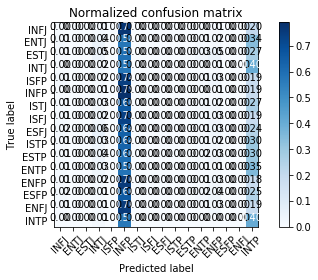

In [28]:
#confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(list(test_y), y_pred_label, labels=classifiers)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
#fig=plt.figure()
#plot_confusion_matrix(cnf_matrix, classes=classifiers,
#                      title='Confusion matrix, without normalization')

#Plot normalized confusion matrix
fig = plt.figure()
plot_confusion_matrix(cnf_matrix, classes=classifiers, normalize=True,
                      title='Normalized confusion matrix')

#plt.show()

fig.savefig('nbow_mbti16-baseline-confusion.png')

In [22]:
import collections
counter=collections.Counter(y_pred_label)
counter

Counter({'INFP': 57941,
         'INTP': 23241,
         'ENTP': 431,
         'ENFP': 1060,
         'INTJ': 1419,
         'INFJ': 472,
         'ESTJ': 5})

In [25]:
counter=collections.Counter(df['type'])

In [26]:
counter

Counter({'INFJ': 1470,
         'ENTP': 685,
         'INTP': 1304,
         'INTJ': 1091,
         'ENTJ': 231,
         'ENFJ': 190,
         'INFP': 1832,
         'ENFP': 675,
         'ISFP': 271,
         'ISTP': 337,
         'ISFJ': 166,
         'ISTJ': 205,
         'ESTP': 89,
         'ESFP': 48,
         'ESTJ': 39,
         'ESFJ': 42})